## 경희대학교 산업경영공학과 2020-1학기 창의적 종합설계

### [3팀] 김동혁 김승원 김태호 김호성 유정수

FaceNet을 활용하여 Face-Recongnition System을 구현한다


https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/ 을 참조하였음

## 예제 데이터(5명의 연예인)를 FaceNet의 Transfer Learning으로 학습하여 얼굴인식 모델 구현

나아가 경희대학교 산업경영공학과의 학생들의 사진으로 데이터를 대체할 예정입니다

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/facenet-keras/facenet_keras.h5
/kaggle/input/5-celebrity-faces-dataset/val/jerry_seinfeld/httpblognjcomentertainmentimpactcelebritiesmediumjerrybjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/jerry_seinfeld/httpcdnssninsidercomwpcontentuploadsjerryseinfeldxjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/jerry_seinfeld/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTIwNjANjMMDINzIxNjcjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/jerry_seinfeld/httpcdncdnjustjaredcomwpcontentuploadsheadlinesjerryseinfeldmakesbrianwilliamsjokejpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/jerry_seinfeld/httpaurorasblogcomwpcontentuploadsjerryseinfeldpublicityshotjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/elton_john/httpcdncdnjustjaredcomwpcontentuploadsheadlineseltonjohnsupportsbrucejennerstransitiontowomanjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/elton_john/httpcdncdnjustjaredcomwpcontentuploadsheadlineseltonjohnstillstandingbrooklynnewyearsjp

## Load a FaceNet Model in Keras

In [2]:
from keras.models import load_model


Using TensorFlow backend.


In [3]:
model = load_model('../input/facenet-keras/facenet_keras.h5')
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Identity:0' shape=(None, 128) dtype=float32>]


/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Detect Faces for Face Recognition
Using MTCNN(Multi-Task Cascaded Convolutional Neural Network)

In [4]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 3.4 MB/s 


In [5]:
import mtcnn
print(mtcnn.__version__)

0.1.0


In [6]:
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array
 


In [7]:
from os import listdir
from matplotlib import pyplot as plt
from keras.preprocessing import image

## Import Dataset Faces
Perform simple project with 5-celebrity-faces-dataset

In [8]:
folder = '../input/5-celebrity-faces-dataset/train/ben_afflek/'

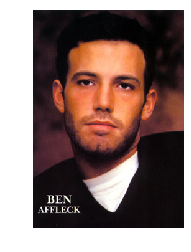

In [9]:
fig, ax = plt.subplots()
img = image.load_img('../input/5-celebrity-faces-dataset/train/ben_afflek/httpwwwallposterscomimagesPostersPFjpg.jpg')
img = image.img_to_array(img)
ax.imshow(img / 255.) 
ax.axis('off')
plt.show()

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


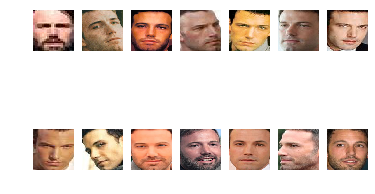

In [10]:
i = 1
#enumerate files
for filename in listdir(folder):
    path = folder + filename
    face = extract_face(path)
    print(i,face.shape)
    
    plt.subplot(2,7,i)
    plt.axis('off')
    plt.imshow(face)
    i += 1
plt.show()

**load_faces()** function below will load all of the faces into a list for a given directory

In [11]:
def load_faces(directory):
    faces = list()
    #enumerate files
    for filename in listdir(directory):
        #path
        path = directory + filename
        #get face
        face = extract_face(path)
        #store
        faces.append(face)
    return faces

**load_dataset()** function below take a directory name and detects faces for each subdirectory, 
also assign labels to each detected face

In [12]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
                continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [13]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from numpy import load
from numpy import expand_dims
from mtcnn.mtcnn import MTCNN

In [14]:
# load train dataset
trainX, trainy = load_dataset('../input/5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('../input/5-celebrity-faces-dataset/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 21 examples for class: jerry_seinfeld
>loaded 17 examples for class: elton_john
>loaded 14 examples for class: ben_afflek
>loaded 19 examples for class: madonna
>loaded 22 examples for class: mindy_kaling
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling
(25, 160, 160, 3) (25,)


## Create Face Embeddings

In [15]:
# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


**get_embedding()** function defined below implements these behaviors and will return a face embedding given a single image of a face and the loaded FaceNet model

In [16]:
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [17]:
# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('../input/facenet-keras/facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
Loaded Model
(93, 128)
(25, 128)


## Perform Face Classification

In this section, we will develop a model to classify face embeddings as one of the known celebrities in the 5 Celebrity Faces Dataset.

1. **normalize** the face embedding vectors 
2. the string target variables for each celebrity name need to be **converted** to integers.
3. **fit** a model (It is common to use a Linear Support Vector Machine (SVM) when working with normalized face embedding inputs)
4. **evaluate** the model -> This can be achieved by using the fit model to make a prediction for each example in the train and test datasets and then calculating the classification accuracy.

In [18]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


### plotting the original face and the prediction.

predicting the identity for a given unseen photo in the test dataset is listed below

Predicted: ben_afflek (58.461)
Expected: ben_afflek


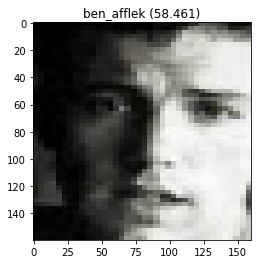

In [19]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()